In [1]:
import torch
import torch.nn as nn
from d2l import torch as d2l
import pandas as pd
import os

import numpy as np

In [43]:
d2l.DATA_HUB['ml-100k'] = (
    'https://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

#@save
def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), sep='\t',
                       names=names, engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

data = read_data_ml100k()
data[0]["rating"].mean()

3.52986

In [202]:
def get_user_histories():
    data, num_users, num_items = read_data_ml100k()

    user_histories = {"user_id": [], "history": []}

    for user_id, group in data.groupby('user_id'):
        group = group.sort_values(by="timestamp")

        user_histories["user_id"].append(user_id)
        user_histories["history"].append(group["item_id"].to_list())

    return pd.DataFrame(user_histories), num_users, num_items

def get_loader(histories, max_history_len, batch_size):
    X = []
    y = []
    
    for idx, row in histories.iterrows():
        ids = [0 for i in range(max_history_len)]
        
        for i in range(len(row["history"]) - 1):
            ids[i] = row["history"][i]
        
        X.append(ids)
        y.append(row["history"][-1])

    X = np.array(X)
    y = np.array(y)

    print(X.shape, y.shape)

    tensor_dataset = TensorDataset(
        torch.tensor(X),
        torch.tensor(y)
    )

    print("batch_size", batch_size)
    
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    return loader

def get_train_test_loaders(batch_size=64, test_size=0.1):
    user_histories, num_users, num_items = get_user_histories()

    train_users = set(user_histories["user_id"].sample(frac=1 - test_size, random_state=137).to_list())
    test_users  = set(range(1, num_users + 1)).difference(train_users)

    train_histories = user_histories[user_histories["user_id"].isin(train_users)]
    test_histories = user_histories[user_histories["user_id"].isin(test_users)]

    max_history_len = max(
        train_histories["history"].apply(lambda x: len(x)).max(),
        test_histories["history"].apply(lambda x: len(x)).max()
    )

    print("max_history_len", max_history_len)

    train_laoder = get_loader(train_histories, max_history_len, batch_size)
    test_laoder = get_loader(test_histories, max_history_len, batch_size)

    return train_laoder, test_laoder, num_users, num_items


In [209]:
train_loader, test_loader, num_users, num_items = get_train_test_loaders(batch_size=2, test_size=0.1)

for _ in train_loader:
    print(_)
    break

num_users, num_items

max_history_len 737
(849, 737) (849,)
batch_size 2
(94, 737) (94,)
batch_size 2
[tensor([[269, 286, 292,  ...,   0,   0,   0],
        [269, 286, 300,  ...,   0,   0,   0]]), tensor([334, 275])]


(943, 1682)

In [217]:
class IntentModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_intents):
        super().__init__()
        self.items = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        self._num_intents = num_intents

        # for i in range(num_intents):
        #     self.enc_red.append(torch.nn.Sequential(
                
        #     ))

        self.intent_matrix = nn.Linear(embedding_dim, num_intents)
        self.intent_id = nn.Sigmoid()        

        self.linear = nn.Linear(
            in_features=embedding_dim,
            out_features=num_embeddings,
        )

    def forward(self, x):
        x = self.items(x)
        intents = self.intent_matrix(x)
        intents = self.intent_id(intents)

        print(x.shape)
        print(x)
        print(intents.shape)
        print(intents)
        
        x = torch.bmm(intents.mT, x)

        x = self.linear(x)
        # print(x.shape)
        # best_score = torch.zeros_like(x).scatter(1, x.argmax(dim=1, keepdim=True), value=1)
        # print(best_score.shape)
        
        # # x_max = torch.max(x, dim=1).indices
        # # print(torch.argmax(x, dim=1, keepdim=True).shape)
        
        # print(torch.flatten(x).shape)
        # print((torch.flatten(best_score).int() > 0).shape)

        # print("wow")
        # wow = torch.index_select(torch.flatten(x), 0, torch.flatten(x.argmax(dim=1, keepdim=True)))
        # print(wow.shape)
        # print(wow)

        output = torch.index_select(torch.flatten(x), 0, torch.flatten(x.argmax(dim=1, keepdim=True))).view(x.shape[0], x.shape[2])

        # output = x * best_score

        # print(output.shape)
        # print(output)

        return output

def calculate_loss(net, iter):
    criterion = nn.CrossEntropyLoss()

    loss_ = 0
    total = 0

    for idx, (tokens, target) in enumerate(iter):
        loss_ += criterion(net(tokens), target).item()
        total   += target.size()[0]

    return loss_ / total

def calculate_accuracy(net, iter):
    criterion = nn.CrossEntropyLoss()

    correct = 0
    total   = 0

    for idx, (tokens, target) in enumerate(iter):
        predict = torch.argmax(nn.functional.softmax(net(tokens)), dim=1)
        correct += torch.sum(predict == target).item()
        total   += target.size()[0]

    return correct / total

In [218]:
model = IntentModel(1682, 4, 5)

for (X, y) in train_loader:
    print(model(X))
    break

torch.Size([2, 737, 4])
tensor([[[ 0.6773,  1.3459, -2.4323, -0.1398],
         [-0.6462,  0.0366, -0.6432,  0.1908],
         [ 1.4361,  1.3077,  0.9509, -0.7193],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[-1.6530, -0.5936, -0.1877, -1.7609],
         [-1.1306,  0.6487, -0.0665, -1.1590],
         [ 0.3843, -0.2649, -0.1488,  1.5121],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]], grad_fn=<EmbeddingBackward0>)
torch.Size([2, 737, 5])
tensor([[[0.6814, 0.7077, 0.6662, 0.1872, 0.4662],
         [0.4759, 0.4644, 0.6981, 0.6164, 0.5580],
         [0.7317, 0.5164, 0.2034, 0.4316, 0.3247],
         ...,
         [0.5100, 0.4857, 0.5470, 0.6213, 0.5231],
         [0.5100, 0.4857, 0.5470, 0.6213, 0.5231],
         [0.5100, 0.4857, 0.5470, 0.6213, 0.5231]],

    

In [208]:
num_embeddings = num_items + 1
embedding_dim = 16
num_intents = 1

model = IntentModel(num_embeddings, embedding_dim, num_intents)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10

train_loss = []
train_accuracy = []
test_loss  = []
test_accuracy = []

is_val = True

print(model)

for epoch in range(num_epochs):
    for idx, (tokens, target) in enumerate(train_loader):
        # Set gradients to zero
        optimizer.zero_grad()

        # Predict and calculate loss
        prediction = model(tokens)

        loss = loss_func(prediction, target.long())

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

    train_loss.append(calculate_loss(model, train_loader))
    train_accuracy.append(calculate_accuracy(model, train_loader))
    test_loss.append(calculate_loss(model, test_loader))
    test_accuracy.append(calculate_accuracy(model, test_loader))

    if is_val:
        print("Epoch:", epoch)
        print("Train loss", train_loss[-1])
        print("Train accuracy", train_accuracy[-1])
        print("Test loss", test_loss[-1])
        print("Test accuracy", test_accuracy[-1])

IntentModel(
  (items): Embedding(1683, 16, padding_idx=0)
  (intent_matrix): Linear(in_features=16, out_features=1, bias=True)
  (intent_id): Sigmoid()
  (linear): Linear(in_features=16, out_features=1683, bias=True)
)
Epoch: 0
Train loss 0.2321353554725647
Train accuracy 0.0
Test loss 0.2321353554725647
Test accuracy 0.0


/var/folders/dz/7q462fh56rg95y4_6lnqmrvr0000gq/T/ipykernel_37170/2917603684.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict = torch.argmax(nn.functional.softmax(net(tokens)), dim=1)


Epoch: 1
Train loss 0.2321353554725647
Train accuracy 0.0
Test loss 0.2321353554725647
Test accuracy 0.0
Epoch: 2
Train loss 0.2321353554725647
Train accuracy 0.0
Test loss 0.2321353554725647
Test accuracy 0.0
Epoch: 3
Train loss 0.2321353554725647
Train accuracy 0.0
Test loss 0.2321353554725647
Test accuracy 0.0
Epoch: 4
Train loss 0.2321353554725647
Train accuracy 0.0
Test loss 0.2321353554725647
Test accuracy 0.0
Epoch: 5
Train loss 0.2321353554725647
Train accuracy 0.0
Test loss 0.2321353554725647
Test accuracy 0.0
Epoch: 6
Train loss 0.2321353554725647
Train accuracy 0.0
Test loss 0.2321353554725647
Test accuracy 0.0
Epoch: 7
Train loss 0.2321353554725647
Train accuracy 0.0
Test loss 0.2321353554725647
Test accuracy 0.0
Epoch: 8
Train loss 0.2321353554725647
Train accuracy 0.0
Test loss 0.2321353554725647
Test accuracy 0.0
Epoch: 9
Train loss 0.2321353554725647
Train accuracy 0.0
Test loss 0.2321353554725647
Test accuracy 0.0


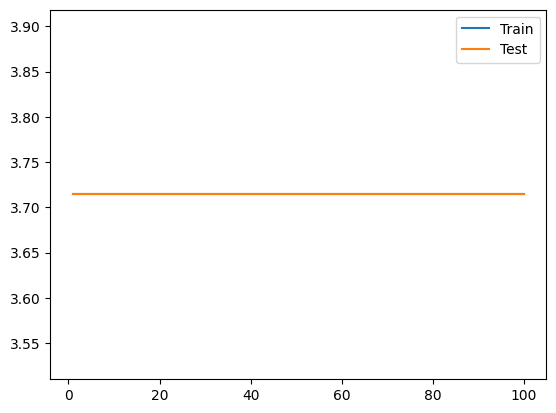

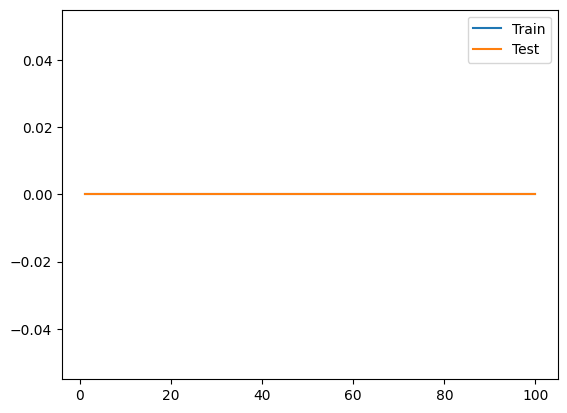

In [193]:
import matplotlib.pyplot as plt 

x = list(range(1, num_epochs + 1))

plt.plot(x, train_loss, label="Train")
plt.plot(x, test_loss, label = "Test")
plt.legend(loc='best')
plt.show()

plt.plot(x, train_accuracy, label="Train")
plt.plot(x, test_accuracy, label = "Test")
plt.legend(loc='best')
plt.show()